# Figures 7-8


In [3]:
import os
from typing import List, Optional

import torch
from lightning import LightningDataModule
from scimilarity_gred.tiledb_sample_data_models import SampleCellsDataModule_disease, scDataset_disease
from torch.utils.data import Dataset, DataLoader

# from cellm.data.data_structures import CellSample
import pickle

from dataclasses import dataclass

import torch
import json


# @dataclass
# class CellSample:
#     x: torch.Tensor
#     pad: torch.Tensor
#     disease_label: torch.Tensor
#     disease_emb: torch.Tensor

#     @staticmethod
#     def collate(batch):
#         device = batch[0].x.device
#         collated = {}
#         keys = batch[0].__dict__.keys()
#         for key in keys:
#             # print(key)
#             attribute_list = [getattr(b, key) for b in batch]
#             collated[key] = torch.stack(attribute_list).to(device=device)
#         return CellSample(**collated)

@dataclass
class CellSample:
    x: torch.Tensor
    pad: torch.Tensor
    disease_label: torch.Tensor
    disease_emb: torch.Tensor
    tissue_label: torch.Tensor
    celltype_label: torch.Tensor

    @staticmethod
    def collate(batch):
        device = batch[0].x.device
        
        # Initialize a dictionary to store collated tensors
        collated = {
            key: torch.stack([getattr(b, key) for b in batch], dim=0).to(device=device)
            for key in batch[0].__dict__.keys()
        }
        
        return CellSample(**collated)

@dataclass
class CellDataMasked(CellSample):
    mask: torch.Tensor


tiledb_base_path = '/projects/global/gred/resbioai/CeLLM/tiledb'

CELLURI = "scimilarity_human_10x_cell_metadata"
GENEURI = "scimilarity_human_10x_gene_metadata"
COUNTSURI = "scimilarity_human_10x_counts"

cell_tdb_uri = os.path.join(tiledb_base_path, CELLURI)
gene_tdb_uri = os.path.join(tiledb_base_path, GENEURI)
counts_tdb_uri = os.path.join(tiledb_base_path, COUNTSURI)

gene_order = "/gstore/data/omni/scdb/cleaned_h5ads/gene_order.tsv"


# def get_default_val_studies():
#     val_studies = [
#         "24d42e5e-ce6d-45ff-a66b-a3b3b715deaf",
#         "29f92179-ca10-4309-a32b-d383d80347c1",
#         "2a79d190-a41e-4408-88c8-ac5c4d03c0fc",
#         "60358420-6055-411d-ba4f-e8ac80682a2e",
#         "7d7cabfd-1d1f-40af-96b7-26a0825a306d",
#         "8191c283-0816-424b-9b61-c3e1d6258a77",
#         "9b02383a-9358-4f0f-9795-a891ec523bcc",
#         "a98b828a-622a-483a-80e0-15703678befd",
#         "b3e2c6e3-9b05-4da9-8f42-da38a664b45b",
#         "be21c2d1-2392-47d0-96fb-c625d115e0dc",
#         "DS000010060",
#         "DS000010475",
#         "DS000011735",
#         "e2a4a67f-6a18-431a-ab9c-6e77dd31cc80",
#         "fcb3d1c1-03d2-41ac-8229-458e072b7a1c",
#     ]
#     return val_studies

def get_default_val_studies(classify_mode='binary'):
 #    val_studies = ['9b02383a-9358-4f0f-9795-a891ec523bcc',
 # 'fcb3d1c1-03d2-41ac-8229-458e072b7a1c',
 # 'a98b828a-622a-483a-80e0-15703678befd',
 # '29f92179-ca10-4309-a32b-d383d80347c1',
 # '8191c283-0816-424b-9b61-c3e1d6258a77',
 # 'b3e2c6e3-9b05-4da9-8f42-da38a664b45b',
 # 'DS000010060',
 # 'DS000011735',
 # '24d42e5e-ce6d-45ff-a66b-a3b3b715deaf',
 # 'DS000010475']

    if classify_mode == 'binary':
        val_studies = ['ddfad306-714d-4cc0-9985-d9072820c530',
                              'DS000010042',
     '436154da-bcf1-4130-9c8b-120ff9a888f2',
                              'DS000010028',
     '7d7cabfd-1d1f-40af-96b7-26a0825a306d',
                                'GSE158034',
                                'GSE158030',
                                'GSE159113',
                                'GSE152522',
                                'GSE153421',
                                'GSE139324',
                                'GSE144430',
                                'GSE134004',
                                'GSE128879']
    elif classify_mode == 'multilabel':
        with open('/projects/site/gred/resbioai/liut61/val_study_commondisease10.json', 'r') as f:
             val_studies = json.load(f)
    elif classify_mode == 'multilabel_final':
        with open('/projects/site/gred/resbioai/liut61/val_study_all.json', 'r') as f:
             val_studies = json.load(f)
    elif classify_mode == 'binary_ct':
        with open('/projects/site/gred/resbioai/liut61/val_study_2diseasect.json', 'r') as f:
             val_studies = json.load(f)
        # with open('/projects/site/gred/resbioai/liut61/test_study_commondisease10.json', 'r') as f:
        #      val_studies = json.load(f)
    return val_studies

def get_default_test_studies(classify_mode='binary'):
 #    test_studies = ['e2a4a67f-6a18-431a-ab9c-6e77dd31cc80',
 # '2a79d190-a41e-4408-88c8-ac5c4d03c0fc',
 # '7d7cabfd-1d1f-40af-96b7-26a0825a306d',
 # '60358420-6055-411d-ba4f-e8ac80682a2e',
 # 'be21c2d1-2392-47d0-96fb-c625d115e0dc']
    if classify_mode == 'binary':
        test_studies = ['DS000010475', 'GSE122703', 'GSE149313', 'GSE167363', 'GSE163668']

    elif classify_mode == 'multilabel':
        with open('/projects/site/gred/resbioai/liut61/test_study_commondisease10.json', 'r') as f:
             test_studies = json.load(f)
    elif classify_mode == 'multilabel_final':
        with open('/projects/site/gred/resbioai/liut61/test_study_all.json', 'r') as f:
             test_studies = json.load(f)
    elif classify_mode == 'binary_ct':
        with open('/projects/site/gred/resbioai/liut61/test_study_2diseasect.json', 'r') as f:
             test_studies = json.load(f)
        # with open('/projects/site/gred/resbioai/liut61/val_study_commondisease10.json', 'r') as f:
        #      test_studies = json.load(f)
    return test_studies


def get_disease_set():
    disease_set = ['healthy', 'COVID-19']
 #    disease_set = ['ulcerative colitis',
 # 'viral encephalitis',
 # 'pancreatic carcinoma',
 # 'COVID-19;healthy',
 # 'juvenile idiopathic arthritis',
 # 'multiple sclerosis',
 # 'idiopathic pulmonary fibrosis',
 # 'atopic eczema',
 # 'non-alcoholic fatty liver disease',
 # 'healthy',
 # 'myocardial infarction',
 # 'monoclonal gammopathy',
 # 'multiple myeloma',
 # 'Tonsillar Squamous Cell Carcinoma',
 # 'basal cell carcinoma',
 # 'systemic lupus erythematosus',
 # 'cystic fibrosis',
 # "Crohn's disease",
 # 'type II diabetes mellitus',
 # 'chronic rhinosinusitis with nasal polyps',
 # 'adenocarcinoma',
 # 'Gastric Metaplasia',
 # 'neuroblastoma',
 # 'fibrosis',
 # 'B-cell lymphoma',
 # 'cutaneous squamous cell carcinoma',
 # 'head and neck squamous cell carcinoma',
 # 'hidradenitis suppurativa',
 # 'liver neoplasm;Uveal Melanoma',
 # 'Uveal Melanoma',
 # 'acute kidney failure',
 # 'drug hypersensitivity syndrome',
 # 'mucocutaneous lymph node syndrome',
 # 'chronic myelogenous leukemia',
 # 'lung adenocarcinoma',
 # 'chronic kidney disease',
 # 'colorectal cancer',
 # "Alzheimer's disease",
 # 'hepatocellular carcinoma',
 # 'medulloblastoma',
 # 'T-cell acute lymphoblastic leukemia',
 # 'Immune dysregulation-polyendocrinopathy-enteropathy-X-linked syndrome',
 # 'COVID-19',
 # 'interstitial lung disease',
 # 'None',
 # 'hypoplastic left heart syndrome',
 # 'chronic obstructive pulmonary disease',
 # 'dengue disease',
 # 'acute myeloid leukemia',
 # 'B-cell acute lymphoblastic leukemia',
 # 'Diamond-Blackfan anemia',
 # 'prostatic hypertrophy',
 # 'glioma',
 # 'dilated cardiomyopathy',
 # 'arrhythmogenic right ventricular cardiomyopathy',
 # 'melanoma',
 # 'gastric cancer',
 # 'intracranial hypotension',
 # "Parkinson's Disease",
 # 'pancreatic ductal adenocarcinoma']

 #    disease_set = ["Alzheimer's disease",
 # 'B-cell acute lymphoblastic leukemia',
 # 'COVID-19',
 # "Crohn's disease",
 # 'None',
 # 'healthy',
 # 'lung adenocarcinoma',
 # 'melanoma',
 # 'multiple myeloma',
 # 'multiple sclerosis']
    
    return disease_set


def get_disease_set_multi():

    disease_set = ["Alzheimer's disease",
 'B-cell acute lymphoblastic leukemia',
 'COVID-19',
 "Crohn's disease",
 # 'None',
 #  '',
 'healthy',
 'lung adenocarcinoma',
 'melanoma',
 'multiple myeloma',
 'multiple sclerosis'
]

#     disease_set = [
#  # 'COVID-19',
#  # "Crohn's disease",
# # "Alzheimer's disease",
# # "lung adenocarcinoma",
# # "multiple sclerosis",
# # "melanoma",
# # 'multiple myeloma',
# 'B-cell acute lymphoblastic leukemia',
#   # '',
#  'healthy'
#     ]
    
    return disease_set

def get_disease_set_final():

    with open('/projects/site/gred/resbioai/liut61/disease_all.json', 'r') as f:
         disease_set = json.load(f)
    
    return disease_set


class scDatasetWrapper(Dataset):
    """
    Wrapper around scimilarity_gred.tiledb_sample_data_models.scDataset dataset.
    In particular:
        - It adds padding if needed
        - It converts the output to CellSample
    """

    def __init__(self, sc_dataset: scDataset_disease, pad_size: int, classify_mode = 'binary', tissue_clean = False):
        self.sc_dataset = sc_dataset
        self.pad_size = pad_size
        # with open("/projects/site/gred/resbioai/liut61/disease_loader.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)


        if classify_mode == 'binary':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_2label.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
        elif classify_mode == 'binary_ct':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_2label.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
            with open("/projects/site/gred/resbioai/liut61/celltype_infomap.pickle", 'rb') as handle:
                self.celltype_label_dict = pickle.load(handle)
        elif classify_mode == 'multilabel':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap9.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
        elif classify_mode == 'multilabel_final':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_all.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
        self.classify_mode = classify_mode
        
        # with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)
        # with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap10.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)

        # self.label_key = {}
        # for key,value in self.disease_label_dict.items():
        #     self.label_key[value] = key
            
        with open("/projects/site/gred/resbioai/liut61/disease_gpt4_description_embeddings.pickle", 'rb') as handle:
            self.disease_emb_dict = pickle.load(handle)

        with open("/projects/site/gred/resbioai/liut61/tissue_loader_all.pickle", 'rb') as handle:
            self.tissue_label_dict = pickle.load(handle)

        if tissue_clean == 'clean':
            with open("/projects/site/gred/resbioai/liut61/tissue_clean_loader.pickle", 'rb') as handle:
                self.tissue_label_dict = pickle.load(handle)

            with open("/projects/site/gred/resbioai/liut61/tissue_clean_map.pickle", 'rb') as handle:
                self.tissue_label_map = pickle.load(handle)

        self.tissue_clean = tissue_clean

    def __getitem__(self, idx: int) -> CellSample:
        sample_i = self.sc_dataset[idx]
        sample_i_X = torch.tensor(sample_i[0]).float()
        disease_label = sample_i[5][0]
        tissue_label = sample_i[4][0]
        # print(disease_label)
        # print(tissue_label)
        global_count_sample.append(sample_i)
        disease_label = self.disease_label_dict[disease_label]
        if self.tissue_clean == False:
            tissue_label = self.tissue_label_dict[tissue_label]
        else:
            tissue_label = self.tissue_label_dict[self.tissue_label_map[tissue_label]]
            
        disease_emb = self.disease_emb_dict[sample_i[5][0]]
        # disease_label = 0
        pad = torch.zeros(self.pad_size, dtype=torch.bool)
        pad[:sample_i_X.shape[0]] = True

        # sample_i_padded = torch.zeros(self.pad_size, sample_i_X.shape[1])
        # sample_i_padded[:sample_i_X.shape[0], :] = sample_i_X
        if self.classify_mode == 'binary_ct':
            celltype_label = [self.celltype_label_dict[i] for i in sample_i[1]]
        else:
            celltype_label = tissue_label
            
        # cell_sample = CellSample(x=sample_i_padded, pad=pad, disease_label=torch.tensor(disease_label) - 1)
        
        # cell_sample = CellSample(x=sample_i_padded, pad=pad, disease_label=torch.tensor(disease_label), disease_emb=torch.FloatTensor(disease_emb), tissue_label=torch.tensor(tissue_label), celltype_label = torch.tensor(celltype_label))
        cell_sample = CellSample(x=sample_i_X, pad=pad, disease_label=torch.tensor(disease_label), disease_emb=torch.FloatTensor(disease_emb), tissue_label=torch.tensor(tissue_label), celltype_label = torch.tensor(celltype_label))
        return cell_sample

    def __len__(self) -> int:
        return len(self.sc_dataset)

class SampleCellsDataModuleCustom(LightningDataModule):
    """
    Convenience class around SampleCellsDataModule
    """

    def __init__(
            self,
            cell_tdb_uri: str = cell_tdb_uri,
            counts_tdb_uri: str = counts_tdb_uri,
            gene_tdb_uri: str = gene_tdb_uri,
            gene_order: str = gene_order,
            val_studies: Optional[List[str]] = None,
            test_studies: Optional[List[str]] = None,
            label_column: str = "celltype_id",
            study_column: str = "study",
            sample_column: str = "sample",
            tissue_column : str = 'tissue',
            disease_column : str = 'disease',
            batch_size: int = 1,
            sample_size: int = 100,
            num_workers: int = 0,
            pad_size: Optional[int] = None,
            precompute_val_test_masking: bool = False,
            disease_set: Optional[int] = None,
            handle_imbalance = False,
            classify_mode = 'binary',
            resample = False,
            tissue_clean = False,
            gene_name = 'genes',
            simple_mode = False
    ):
        super().__init__()
        if val_studies is None:
            val_studies = get_default_val_studies(classify_mode = classify_mode)
        if test_studies is None:
            test_studies = get_default_test_studies(classify_mode = classify_mode)
        if disease_set is None:
            if (classify_mode == 'binary') or (classify_mode == 'binary_ct'):
                disease_set = get_disease_set()
            elif classify_mode == 'multilabel':
                disease_set = get_disease_set_multi()
            elif classify_mode == 'multilabel_final':
                disease_set = get_disease_set_final()
        self.data_module = SampleCellsDataModule_disease(cell_tdb_uri=cell_tdb_uri, counts_tdb_uri=counts_tdb_uri,
                                                 gene_tdb_uri=gene_tdb_uri,
                                                 gene_order=gene_order, val_studies=val_studies, test_studies=test_studies,
                                                 label_id_column=label_column,
                                                 study_column=study_column,
                                                 sample_column=sample_column, batch_size=batch_size,
                                                 sample_size=sample_size,
                                                 num_workers=num_workers,
                                                 tissue_column = tissue_column,
                                                 disease_column = disease_column,
                                                disease_set = disease_set,
                                                handle_imbalance = handle_imbalance, classify_mode = classify_mode, resample = resample, gene_name=gene_name, simple_mode=simple_mode
                                                )
        self.pad_size = pad_size
        if self.pad_size is None:
            self.pad_size = sample_size
        self.precompute_val_test_masking = precompute_val_test_masking

        if self.precompute_val_test_masking:
            # TODO
            raise NotImplementedError

        self.batch_size = batch_size
        self.num_workers = num_workers

        self.train_dataset = scDatasetWrapper(self.data_module.train_dataset, pad_size=self.pad_size, classify_mode=classify_mode, tissue_clean=tissue_clean)
        if self.data_module.val_dataset is not None:
            self.val_dataset = scDatasetWrapper(self.data_module.val_dataset, pad_size=self.pad_size, classify_mode=classify_mode, tissue_clean=tissue_clean)
        if self.data_module.test_dataset is not None:
            self.test_dataset = scDatasetWrapper(self.data_module.test_dataset, pad_size=self.pad_size, classify_mode=classify_mode, tissue_clean=tissue_clean)

        self.save_ct_result = []

    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=False,
            collate_fn=CellSample.collate
        )

    def val_dataloader(self) -> DataLoader:
        if self.val_dataset is None:
            return None

        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=False,
            collate_fn=CellSample.collate
        )

    def test_dataloader(self) -> DataLoader:
        if self.test_dataset is None:
            return None

        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            pin_memory=True,
            drop_last=True,
            shuffle=False,
            collate_fn=CellSample.collate
        )


In [4]:
from typing import Callable, Any, Dict

import lightning as L
import torch
import torchmetrics
# from pl_bolts.optimizers import LinearWarmupCosineAnnealingLR
from torch import nn

from cellm.components.cell_to_cell import CellToCellPytorchTransformer
from cellm.components.cell_to_output import CellToOutputMLP
from cellm.components.gene_to_cell import GeneToCellLinear,GeneToCellMLP
from cellm.components.masking import Masking
# from cellm.data.data_structures import CellSample
import pickle
import json

from pytorch_metric_learning.losses import SelfSupervisedLoss, TripletMarginLoss, NTXentLoss


class MultiTaskLoss(torch.nn.Module):
  '''https://arxiv.org/abs/1705.07115'''
  def __init__(self, is_regression, reduction='none'):
    super(MultiTaskLoss, self).__init__()
    self.is_regression = is_regression
    self.n_tasks = len(is_regression)
    self.log_vars = torch.nn.Parameter(torch.zeros(self.n_tasks))
    self.reduction = reduction

  def forward(self, losses):
    dtype = losses.dtype
    device = losses.device
    stds = (torch.exp(self.log_vars)**(1/2)).to(device).to(dtype)
    self.is_regression = self.is_regression.to(device).to(dtype)
    coeffs = 1 / ( (self.is_regression+1)*(stds**2) )
    multi_task_losses = coeffs*losses + torch.log(stds)

    if self.reduction == 'sum':
      multi_task_losses = multi_task_losses.sum()
    if self.reduction == 'mean':
      multi_task_losses = multi_task_losses.mean()

    return multi_task_losses

class CellClassifyModel(L.LightningModule):
    def __init__(self, num_genes, masking_strategy: Masking, lr: float = 1e-04, weight_decay: float = 0., dropout: float = 0., text_emb = False, attn = 'linear_attn', n_dim = 1024, classify_mode = 'binary', num_layers=2, label_smoothing=0.0, logit_adjustment=False, residual=False, batchnorm = False, include_tissue=False, uncertainty=False, noise_robust=False, label_weight = False, mask_training = False, decoupling = False, n_hidden = 512, n_hidden_num = 2, contras=False, contras_ct = False):
        super().__init__()

        # automatically access hparams with self.hparams.XXX
        self.save_hyperparameters(
            ignore=['gene_to_cell_encoder', 'cell_to_cell_encoder', 'cell_to_output_encoder', 'masking_strategy'])

        self.num_genes = num_genes
        self.masking_strategy = masking_strategy
        # with open("/projects/site/gred/resbioai/liut61/disease_loader.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)
        # with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)

        # with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap10.pickle", 'rb') as handle:
        #     self.disease_label_dict = pickle.load(handle)
        if (classify_mode == 'binary') or (classify_mode == 'binary_ct'):
            with open("/projects/site/gred/resbioai/liut61/disease_loader_2label.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
        elif classify_mode == 'multilabel':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_overlap9.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
        elif classify_mode == 'multilabel_final':
            with open("/projects/site/gred/resbioai/liut61/disease_loader_all.pickle", 'rb') as handle:
                self.disease_label_dict = pickle.load(handle)
            # self.disease_number = len(self.disease_label_dict) - 1
        self.disease_number = len(self.disease_label_dict)
        print(self.disease_number)
        self.classify_mode = classify_mode

        with open("/projects/site/gred/resbioai/liut61/tissue_loader_all.pickle", 'rb') as handle:
            self.tissue_label_dict = pickle.load(handle)
            self.tissue_number = len(self.tissue_label_dict)

        if include_tissue == 'clean':
            with open("/projects/site/gred/resbioai/liut61/tissue_clean_loader.pickle", 'rb') as handle:
                self.tissue_label_dict = pickle.load(handle)
                self.tissue_number = len(self.tissue_label_dict)

        self.uncertainty = uncertainty 
        if self.uncertainty:
            self.uw_class = MultiTaskLoss(torch.Tensor([False, False]), 'mean')
        # self.label_key = {}
        # for key,value in self.disease_label_dict.items():
        #     self.label_key[value] = key
            
        # with open("/projects/site/gred/resbioai/liut61/disease_gpt4_description_embeddings.pickle", 'rb') as handle:
        #     self.disease_emb_dict = pickle.load(handle)
        # self.disease_number = 2
        print(self.disease_number)
        self.logit_adjustment = logit_adjustment
        self.include_tissue = include_tissue
        self.label_weight = label_weight

        if residual:
            self.gene_to_cell_encoder = GeneToCellMLP(self.num_genes, latent_dim=n_dim, hidden_dim = [n_hidden] * n_hidden_num, residual=residual, batchnorm=False, dropout = dropout)
        else:
            self.gene_to_cell_encoder = GeneToCellLinear(self.num_genes, latent_dim=n_dim)

        if self.include_tissue != False:
            self.cell_to_output_tissue_encoder = CellToOutputMLP(input_dim=n_dim , output_dim=self.tissue_number, hidden_dim=[n_hidden] * n_hidden_num, dropout=dropout,residual=residual, batchnorm=batchnorm) # can be 512, 512
        
        if attn  == 'transformer':
            self.cell_to_cell_encoder = CellToCellPytorchTransformer(n_dim , n_heads=4, num_layers=num_layers, single_cell_only=False)
            
        self.cell_to_output_encoder = CellToOutputMLP(input_dim=n_dim , output_dim=self.disease_number, hidden_dim=[n_hidden] * n_hidden_num, dropout=dropout,residual=residual, batchnorm=batchnorm) # can be 512, 512

        if logit_adjustment:
            if self.disease_number == 10:
                self.logit_adj = torch.load("/projects/site/gred/resbioai/liut61/adjusted_logits_data.pkl")
                logit_adj_list = list(self.logit_adj)
                logit_adj_list.insert(4, -10) # hard code to exclude class 4, which is None.
                self.logit_adj = torch.FloatTensor(logit_adj_list)
                print(self.logit_adj)
            else:
                self.logit_adj = torch.load("/projects/site/gred/resbioai/liut61/adjusted_logits_data.pkl")
                print(self.logit_adj)
            
        # if text_emb:
        #     self.cell_to_output_encoder = CellToOutputMLP(input_dim=1024 + 1024, output_dim=self.disease_number, hidden_dim=[512, 512], dropout=dropout)
        self.attn = attn
        self.text_emb = text_emb
        if text_emb:
            self.loss_ssf = SelfSupervisedLoss(TripletMarginLoss())
        self.contras = False
        if contras:
            self.contras = contras
            self.loss_ssf_con =  NTXentLoss()
        self.contras_ct = False
        if contras_ct:
            self.contras_ct = contras_ct
            self.loss_ssf_con =  NTXentLoss()
            
        if attn == 'nonlinear_attn':
            self.attention = nn.Sequential(
                nn.Linear(n_dim , n_dim ), # matrix V
                nn.Tanh(),
                # nn.PReLU(),
                nn.Linear(n_dim, 1) # matrix w (or vector w if self.ATTENTION_BRANCHES==1)
            )

        self.noise_robust = noise_robust
        self.mask_training = mask_training

        if self.mask_training:
            self.mask_loss = nn.MSELoss(reduction='none')
            self.cell_to_rec = CellToOutputMLP(input_dim=n_dim, output_dim=self.num_genes, hidden_dim=[n_hidden] * n_hidden_num)

        self.decoupling = decoupling
        if self.decoupling:
            for param in self.gene_to_cell_encoder.parameters():
                param.requires_grad = False
            # if attn  == 'transformer':
            #     for param in self.cell_to_cell_encoder.parameters():
            #         param.requires_grad = False
            # if attn == 'nonlinear_attn':
            #     for param in self.attention.parameters():
            #         param.requires_grad = False
            self.cell_to_output_encoder = CellToOutputMLP(input_dim=n_dim , output_dim=self.disease_number, hidden_dim=[n_hidden] * n_hidden_num, dropout=dropout,residual=residual, batchnorm=batchnorm) # can be 512, 512, init this module

        self.loss_func = self.get_loss_func(label_smoothing = label_smoothing)
        self.metrics = self.get_metrics()
            
            

    def get_loss_func(self, label_smoothing) -> nn.Module:
  #       return nn.CrossEntropyLoss(weight = torch.tensor([ 0.024203821656050957, 0.0021231422505307855,   0.10912951167728238,
  #  0.02505307855626327,    0.1851380042462845,     0.608067940552017,
  #  0.02038216560509554,  0.008492569002123142,  0.004670912951167728,
  # 0.012738853503184714]))
        if self.label_weight == False:
            return nn.CrossEntropyLoss(label_smoothing=label_smoothing)
        else:
            if self.decoupling:
                return nn.CrossEntropyLoss(label_smoothing=label_smoothing)
            if self.classify_mode == 'multilabel_final':
                with open("/projects/site/gred/resbioai/liut61/disease_weight_all.pickle", 'rb') as handle:
                    weight = pickle.load(handle)
                return nn.CrossEntropyLoss(weight = 1.0 / (torch.tensor(weight) +1e-8) , label_smoothing=label_smoothing)
            else:
                weight = [57,5, 268, 59, 1443, 48, 20, 11, 30]
                return nn.CrossEntropyLoss(weight = 1.0 / torch.tensor(weight) , label_smoothing=label_smoothing)
    

    def get_metrics(self) -> Dict[str, Callable[[torch.tensor, torch.tensor], torch.tensor]]:
        metrics = dict()
        # metrics['accuracy'] = torchmetrics.Accuracy(task="multiclass", num_classes= self.disease_number, average='weighted')
        metrics['accuracy'] = torchmetrics.Accuracy(task="multiclass", num_classes= self.disease_number)

        return metrics

    def compute_loss(self, preds: torch.Tensor, gt: torch.Tensor) -> torch.Tensor:
        loss = self.loss_func(preds, gt).mean()
        return loss

    def weighted_average_nonlinear(self, x):
        # avg_atten = torch.nn.functional.softmax(x, dim=1)
        # x_ = x * avg_atten 
        attn = self.attention(x)
        attn = torch.nn.functional.softmax(attn, dim=1)
        x_ = attn * x
        return x_.sum(axis=1)

    def visualize_attention(self, x):
        attn = self.attention(x)
        attn = torch.nn.functional.softmax(attn, dim=1)
        return attn[:,:,0]
        

    def weighted_average(self, x):
        avg_atten = torch.nn.functional.softmax(x, dim=1)
        x_ = x * avg_atten 
        return x_.sum(axis=1)

    def compute_step(self, batch: CellSample, prefix: str, log=True) -> torch.Tensor:
        x = batch.x
        y_label = batch.disease_label
        if (prefix == 'train') and self.noise_robust:
            x = torch.cat((x, x + torch.randn(x.shape).to(self.device)), 0)
            y_label = torch.cat((y_label,y_label), 0)
            
        if self.mask_training:
            if hasattr(batch, 'mask'):  # precomputed mask
                mask = batch.mask
                x_masked, mask = self.masking_strategy.apply_mask(x, mask)
            else:
                x_masked, mask = self.masking_strategy(x)
        
            o = self.gene_to_cell_encoder(x_masked)  # batch x sample x cell
        else:
            o = self.gene_to_cell_encoder(x)  # batch x sample x cell
        # print(o.shape)
        # o = self.cell_to_cell_encoder(o, src_key_padding_mask=~batch.pad)  # batch x sample x cell
        # o = o.mean(axis=1) # should be sample x embeddings
    

        if self.attn == 'mean':
            o_ = o.mean(axis=1) # should be sample x embeddings
        elif self.attn == 'linear_attn':
            o_ = self.weighted_average(o)
        elif self.attn == 'nonlinear_attn':
            o_ = self.weighted_average_nonlinear(o)
        elif self.attn == 'transformer':
            o = self.cell_to_cell_encoder(o, src_key_padding_mask=~batch.pad)
            o_ = o.mean(axis=1) # should be sample x embeddings
            
        preds = self.cell_to_output_encoder(o_)  # sample x logits

        if self.logit_adjustment:
            preds = preds + self.logit_adj.to(o.device)
        gt = y_label # change it to y as labels
        loss = self.compute_loss(preds, gt)

        if self.contras_ct:
            for i in range(len(o)):
                o_filter = o[i,:,:]
                loss += self.loss_ssf_con(o_filter, batch.celltype_label[i])

        if self.contras:
            loss += self.contras * self.loss_ssf_con(o_, gt)

        if self.mask_training:
            o = self.cell_to_rec(o)
            # loss: keep only masked genes (mask=False), and not padded cells (pad=True)
            loss_mask = (~mask) & batch.pad[..., None]
    
            preds_masked = o[loss_mask]
            gt_masked = x[loss_mask]
    
            loss += self.mask_loss(preds_masked, gt_masked).mean()

        # text embeddings similarity learning
        if self.text_emb:
            # loss += torch.nn.functional.mse_loss(o_, batch.disease_emb)
            loss += self.loss_ssf(o_, batch.disease_emb)

        if self.include_tissue != False:
            o_t = self.cell_to_output_tissue_encoder(o_)
            if self.uncertainty:
                # loss = self.uw_class(torch.cat((loss.reshape(1), self.compute_loss(o_t, batch.tissue_label))), dim=0)
                loss = self.uw_class(torch.stack((loss, self.compute_loss(o_t, batch.tissue_label))))
            else:
                loss += self.compute_loss(o_t, batch.tissue_label)

        if log:
            self.log(f"{prefix}_loss", loss.item(), prog_bar=True, sync_dist=True)
            self._log_metric(prefix, preds, gt)
    
        return loss

    def _log_metric(self, prefix: str, logits: torch.Tensor, gt: torch.Tensor):
        for metric_name, metric_func in self.metrics.items():
            metric_str = f"{prefix}_{metric_name}"
            self.log(metric_str, metric_func(logits, gt).item(), prog_bar=True, sync_dist=True, on_step=False, on_epoch=True)

    def training_step(self, batch: CellSample, batch_idx) -> torch.Tensor:
        return self.compute_step(batch, prefix='train')

    def validation_step(self, batch: CellSample, batch_idx) -> torch.Tensor:
        return self.compute_step(batch, prefix='val')

    def test_step(self, batch: CellSample, batch_idx) -> torch.Tensor:
        return self.compute_step(batch, prefix='test')

    def general_compute(self, batch: CellSample, batch_idx) -> torch.Tensor:
        if torch.cuda.is_available():
            x = batch.x.cuda()
            pad = batch.pad.cuda()
        else:
            x = batch.x
            pad = batch.pad
        o = self.gene_to_cell_encoder(x)
        y_label = batch.disease_label
        if self.attn == 'mean':
            o_ = o.mean(axis=1) # should be sample x embeddings
        elif self.attn == 'linear_attn':
            o_ = self.weighted_average(o)
        elif self.attn == 'nonlinear_attn':
            o_ = self.weighted_average_nonlinear(o)
        elif self.attn == 'transformer':
            o = self.cell_to_cell_encoder(o, src_key_padding_mask=~pad)
            o_ = o.mean(axis=1) # should be sample x embeddings
        return o_


    def forward(self,data, pad=None):
        if torch.cuda.is_available():
            x = data.cuda()
            if self.attn == 'transformer':
                pad = pad.cuda()
        else:
            x = data
        o = self.gene_to_cell_encoder(x)  # batch x sample x cell
        if self.attn == 'mean':
            o_ = o.mean(axis=1) # should be sample x embeddings
        elif self.attn == 'linear_attn':
            o_ = self.weighted_average(o)
        elif self.attn == 'nonlinear_attn':
            o_ = self.weighted_average_nonlinear(o)
        elif self.attn == 'transformer':
            o = self.cell_to_cell_encoder(o, src_key_padding_mask=~pad)
            o_ = o.mean(axis=1) # should be sample x embeddings
            
        o = self.cell_to_output_encoder(o_)  # sample x logits
        return o
        

    def obtain_annotation(self, batch:CellSample, batch_index):
        o = self.general_compute(batch, batch_index)
        # if self.text_emb:
        #     o = torch.cat([o, batch.disease_emb], axis=1)
        o = self.cell_to_output_encoder(o)  # batch x sample x cell

        if self.logit_adjustment:
            o = o + self.logit_adj.to(o.device)
        preds = o
        _, predicted = torch.max(preds, 1)
        probs = torch.softmax(o, 1)
        return predicted, probs

    def obtain_embeddings(self, batch:CellSample, batch_index) -> torch.Tensor:
        o = self.general_compute(batch, batch_index)
        return o # this o should be the patient embeddings
    

    def on_fit_start(self):
        # fix metrics devices
        for k, v in self.metrics.items():
            self.metrics[k] = v.to(self.device)

    def on_test_start(self):
        # fix metrics devices
        for k, v in self.metrics.items():
            self.metrics[k] = v.to(self.device)

    def configure_optimizers(self) -> Dict[str, Any]:
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr, weight_decay=self.hparams.weight_decay)
        # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
        return optimizer
        # return {
        #         "optimizer": optimizer,
        #         "lr_scheduler": {
        #             "scheduler": scheduler,
        #             "monitor": "val_loss",
        #             "interval": "epoch",
        #             # If "monitor" references validation metrics, then "frequency" should be set to a
        #             # multiple of "trainer.check_val_every_n_epoch".
        #         },
        #     }

In [5]:
import random
from lightning.pytorch import Trainer, seed_everything
seed_everything(0, workers=True)
scd = SampleCellsDataModuleCustom(batch_size = 1, sample_size=1500, classify_mode ='multilabel', resample=False)

Seed set to 0


["Alzheimer's disease", 'B-cell acute lymphoblastic leukemia', 'COVID-19', "Crohn's disease", 'healthy', 'lung adenocarcinoma', 'melanoma', 'multiple myeloma', 'multiple sclerosis']
Training data size: (8237589, 7)
Validation data size: (1935571, 7)
Testing data size: (1566887, 7)
1941
474
359


In [6]:
global_count_sample = scd.save_ct_result

In [7]:
from captum.attr import IntegratedGradients
from captum.attr import Occlusion
from captum.attr import GradientShap
from captum.attr import LRP
from captum.attr import Occlusion
from captum.attr import NoiseTunnel
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule, GammaRule, Alpha1_Beta0_Rule

In [ ]:
f1score_list = []
finalauroc_list = []
from sklearn.metrics import classification_report #1e-3, best save
from sklearn.metrics import roc_auc_score
class_model = CellClassifyModel.load_from_checkpoint("../disease2classlr1e4_wd1e4_batch32_epoch20_drop0.0_cells1500_multilabel_updatelabel_diseasetissue_labelweight_ftcount_nonlinear-attn_new_epoch=00-val_accuracy=0.77 (t068).ckpt", num_genes=28231, masking_strategy=None, attn = 'nonlinear_attn', batchnorm=False)
ig = IntegratedGradients(class_model)


In [13]:
class_model.disease_label_dict

{"Alzheimer's disease": 0,
 'B-cell acute lymphoblastic leukemia': 1,
 'COVID-19': 2,
 "Crohn's disease": 3,
 'healthy': 4,
 'lung adenocarcinoma': 5,
 'melanoma': 6,
 'multiple myeloma': 7,
 'multiple sclerosis': 8}

In [14]:
torch.cuda.is_available()

True

In [15]:
task = 'gene'

In [11]:
if task == 'gene':
    attributions_list = []
    approximation_error_list = []
    label_list = []
    if torch.cuda.is_available():
        for i in scd.test_dataloader():
            baselines = torch.zeros_like(i.x).to('cuda')
            attributions, approximation_error = ig.attribute(i.x.to('cuda'),
                                                             baselines=baselines,
                                                             target=i.disease_label,
                                                             return_convergence_delta=True)
            attributions_list.append(attributions.cpu().numpy())
            approximation_error_list.append(approximation_error.cpu().numpy())
            label_list.append(i.disease_label.item())
    else:
        for i in scd.test_dataloader():
            baselines = torch.zeros_like(i.x)
            attributions, approximation_error = ig.attribute(i.x,
                                                             baselines=baselines,
                                                             target=i.disease_label,
                                                             return_convergence_delta=True)
            attributions_list.append(attributions)
            approximation_error_list.append(approximation_error)
            label_list.append(i.disease_label.item())

if task == 'celltype':
    attributions_list = []
    approximation_error_list = []
    label_list = []
    if torch.cuda.is_available():
        for i in scd.train_dataloader():
            baselines = torch.zeros_like(i.x).to('cuda')
            attributions, approximation_error = ig.attribute(i.x.to('cuda'),
                                                             baselines=baselines,
                                                             target=i.disease_label,
                                                             return_convergence_delta=True, n_steps=10)
            attributions_list.append(attributions.cpu().numpy().mean(axis=2))
            approximation_error_list.append(approximation_error.cpu().numpy().mean(axis=2))
            label_list.append(i.disease_label.item())
    else:
        for i in scd.train_dataloader():
            baselines = torch.zeros_like(i.x)
            attributions, approximation_error = ig.attribute(i.x,
                                                             baselines=baselines,
                                                             target=i.disease_label,
                                                             return_convergence_delta=True, n_steps=10)
            attributions_list.append(attributions.numpy().mean(axis=2))
            approximation_error_list.append(approximation_error.numpy().mean(axis=2))
            label_list.append(i.disease_label.item())
    

In [12]:

len(scd.save_ct_result)

359

In [13]:
# !nvidia-smi

In [14]:
# label_list

In [16]:
len(scd.save_ct_result)

0

In [16]:
len(scd.save_ct_result)

359

In [17]:
item_dict = {}
for i in class_model.disease_label_dict.values():
    item_dict[i] = []

In [18]:
for i,j in zip(attributions_list,label_list):
    item_dict[j].append(i.mean(axis=1)[0])

NameError: name 'attributions_list' is not defined

In [20]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'x': [1, 2, 3, 4, 5],
#     'y': [2, 3, 5, 7, 8],
#     'color': [10, 20, 30, 40, 50],
#     'size': [100, 200, 300, 400, 500]  # Bubble sizes
# }
# df = pd.DataFrame(data)

# # Create the plot
# plt.figure(figsize=(10, 6))
# bubble = plt.scatter('x', 'y', s='size', c='color', alpha=0.5, data=df)

# # Adding color bar
# plt.colorbar(bubble, label='Color Scale')

# # Create legends for sizes
# for size in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.3, s=size,
#                 label=str(size) + ' Size')
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Bubble Sizes')

# # Labeling
# plt.xlabel('X Axis Label')
# plt.ylabel('Y Axis Label')
# plt.title('Bubble Plot Example with Size Legend')

# # Show plot
# plt.show()


In [22]:
healthy_average = []
disease_average = []
for i,j in zip(attributions_list,label_list):
    if j == 0:
        healthy_average.append(i.mean(axis=1)[0])
    else:
        disease_average.append(i.mean(axis=1)[0])  

In [23]:
class_model.disease_label_dict

{"Alzheimer's disease": 0,
 'B-cell acute lymphoblastic leukemia': 1,
 'COVID-19': 2,
 "Crohn's disease": 3,
 'healthy': 4,
 'lung adenocarcinoma': 5,
 'melanoma': 6,
 'multiple myeloma': 7,
 'multiple sclerosis': 8}

In [15]:
disease_label_dict = {"Alzheimer's disease": 0,
 'B-cell acute lymphoblastic leukemia': 1,
 'COVID-19': 2,
 "Crohn's disease": 3,
 'healthy': 4,
 'lung adenocarcinoma': 5,
 'melanoma': 6,
 'multiple myeloma': 7,
 'multiple sclerosis': 8}

In [16]:
class_label_todisease = {}
for key,value in disease_label_dict.items():
    class_label_todisease[value] = key

In [17]:
import numpy as np

In [18]:
np.array(item_dict[0]).shape

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (57,) + inhomogeneous part.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

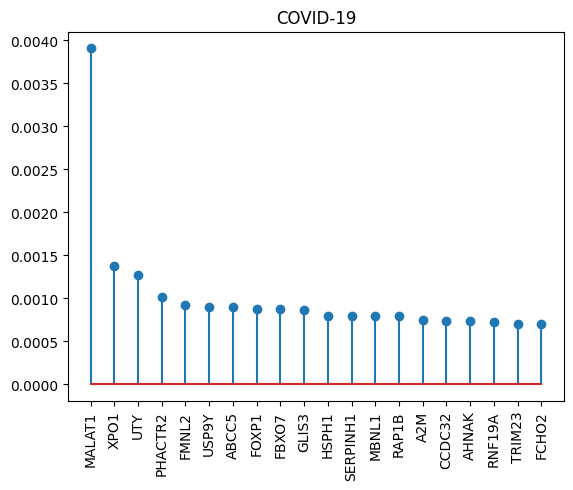

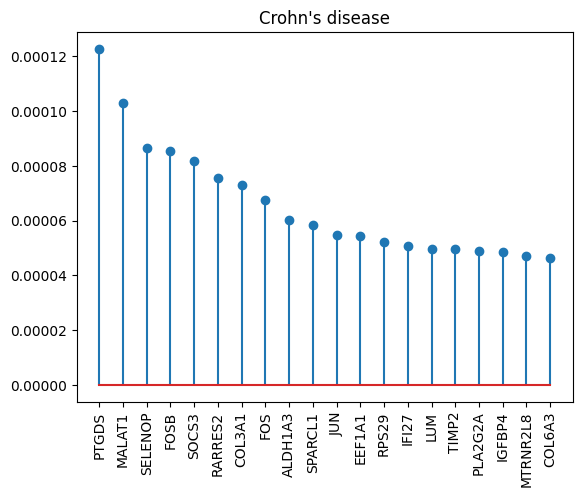

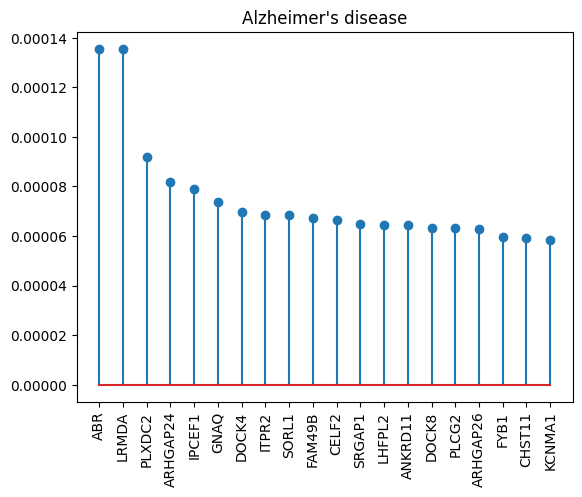

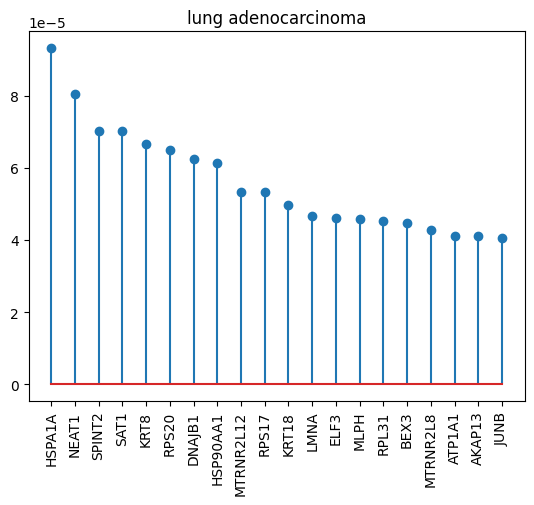

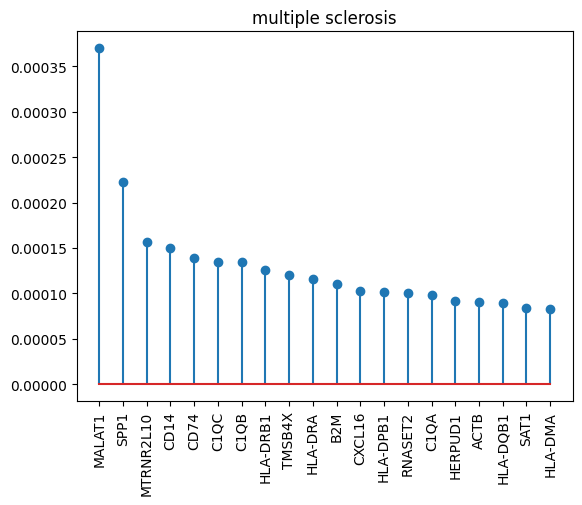

In [30]:
for index_id in [2,3,0,5,8]:
    disease_data = pd.DataFrame()
    disease_data['data'] = np.array(item_dict[index_id]).mean(axis=0)
    disease_data.index = scd.data_module.gene_order
    useful_list = []
    for item in disease_data.index:
        if 'MT-' not in item:
            useful_list.append(item)
    disease_data = disease_data.loc[useful_list]
    # disease_data_sort = disease_data.sort_values('data',ascending=False)
    # disease_data_sort = disease_data_sort[disease_data_sort['data']>0]
    plt.figure()
    plt.stem(disease_data.sort_values('data',ascending=False).iloc[0:20].index, disease_data.sort_values('data',ascending=False).iloc[0:20])
    plt.title(class_label_todisease[index_id])
    plt.xticks(rotation=90)
    plt.show()

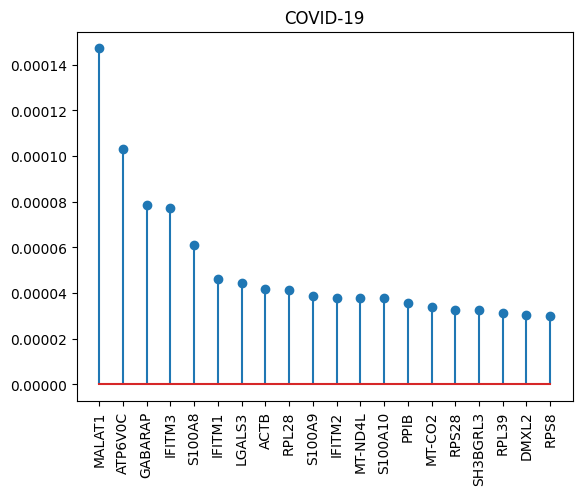

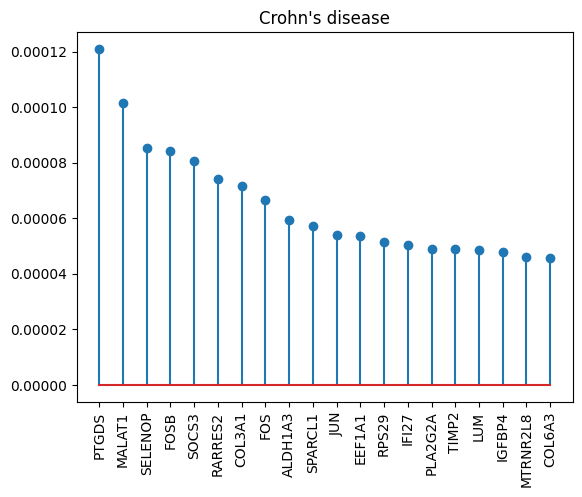

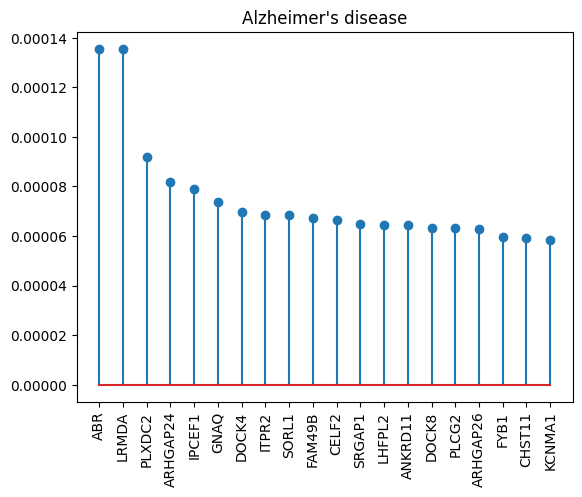

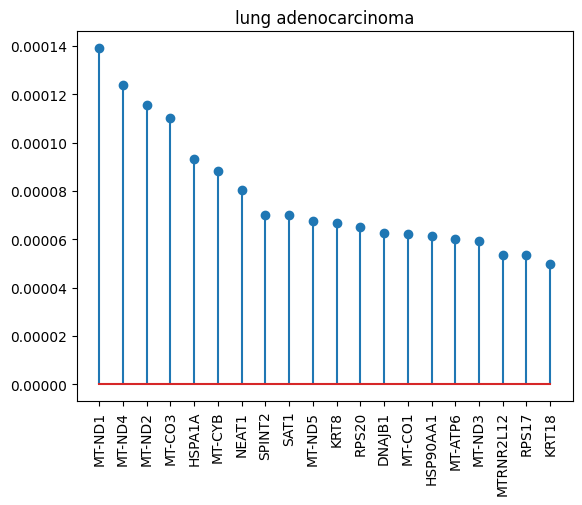

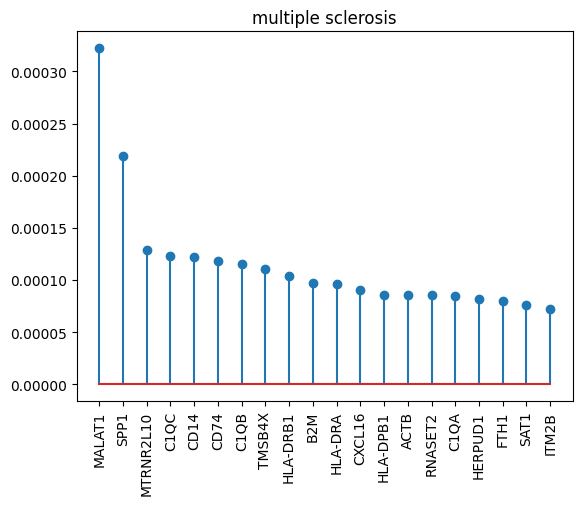

In [29]:
for index_id in [2,3,0,5,8]:
    disease_data = pd.DataFrame()
    disease_data['data'] = np.array(item_dict[index_id]).mean(axis=0)
    disease_data.index = scd.data_module.gene_order
    # disease_data_sort = disease_data.sort_values('data',ascending=False)
    # disease_data_sort = disease_data_sort[disease_data_sort['data']>0]
    plt.figure()
    plt.stem(disease_data.sort_values('data',ascending=False).iloc[0:20].index, disease_data.sort_values('data',ascending=False).iloc[0:20])
    plt.title(class_label_todisease[index_id])
    plt.xticks(rotation=90)
    plt.show()

In [ ]:
plt.stem(disease_data.sort_values('data',ascending=False).iloc[0:20].index, disease_data.sort_values('data',ascending=False).iloc[0:20])
plt.xticks(rotation=90)
plt.show()

In [19]:
ct_dict = {}
for i in class_model.disease_label_dict.values():
    ct_dict[i] = []

In [20]:
item_dict = {}
for i in class_model.disease_label_dict.values():
    item_dict[i] = []

In [21]:
# for i,j,ctl in zip(attributions_list,label_list,scd.save_ct_result):
#     item_dict[j].append(i.cpu().numpy().mean(axis=2)[0])
#     ct_dict[j].append(ctl[1])

for i,j,ctl in zip(attributions_list,label_list,scd.save_ct_result):
    item_dict[j].append(i)
    ct_dict[j].append(ctl[1])
        
        

In [22]:
# ct_dict[2]

In [23]:
item_dict[0]

[array([1.06187122e-06, 1.68949251e-07, 9.98740418e-09, ...,
        1.21878749e-08, 1.15383597e-08, 7.24322806e-10]),
 array([-7.12850224e-09,  2.41655538e-07,  1.40557397e-07, ...,
         3.64989421e-08,  7.64785329e-07,  3.55227292e-07]),
 array([-1.52987101e-06,  3.93926762e-09,  2.86592002e-08, ...,
         3.20438874e-08,  5.96873544e-07,  4.84110600e-06]),
 array([5.53678496e-08, 6.69628580e-06, 1.94862767e-08, ...,
        2.34658469e-07, 3.53714472e-08, 7.60522057e-08]),
 array([ 1.95855562e-09,  1.67153492e-08, -2.74965233e-07, ...,
         2.82849488e-08,  1.56715132e-07,  1.28930118e-08]),
 array([-7.03788086e-08,  1.63108044e-06,  2.99790436e-07, ...,
        -8.14222831e-07,  9.05970241e-07,  6.54044970e-06]),
 array([-1.83968276e-07,  1.75405657e-09,  1.11238159e-08, ...,
         5.20850191e-06, -3.45601762e-07,  1.10791593e-07]),
 array([ 1.61254542e-07,  2.06518811e-06,  3.20590818e-06, ...,
         1.33050946e-08,  1.52146693e-07, -1.72849527e-07]),
 array([ 8.3

In [2]:
import pickle

In [3]:
# with open('/projects/site/gred/resbioai/liut61/disease_9_data_fulltrain.pickle', 'wb') as handle:
#     pickle.dump(item_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('/projects/site/gred/resbioai/liut61/disease_9_celltype_fulltrain.pickle', 'wb') as handle:
#     pickle.dump(ct_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)


# with open('/projects/site/gred/resbioai/liut61/disease_9_data.pickle', 'rb') as handle:
#     item_dict = pickle.load(handle)
# with open('/projects/site/gred/resbioai/liut61/disease_9_celltype.pickle', 'rb') as handle:
#     ct_dict = pickle.load(handle)

with open('/projects/site/gred/resbioai/liut61/disease_9_data_fulltrain.pickle', 'rb') as handle:
    item_dict = pickle.load(handle)
with open('/projects/site/gred/resbioai/liut61/disease_9_celltype_fulltrain.pickle', 'rb') as handle:
    ct_dict = pickle.load(handle)

In [4]:
all_celltype = []
for i in ct_dict.keys():
    for j in ct_dict[i]:
        for k in j:
            all_celltype.append(str(k))

In [5]:
set(all_celltype)

{'B cell',
 'CD14-low, CD16-positive monocyte',
 'CD14-positive monocyte',
 'CD14-positive, CD16-positive monocyte',
 'CD16-negative, CD56-bright natural killer cell, human',
 'CD16-positive, CD56-dim natural killer cell, human',
 'CD1c-positive myeloid dendritic cell',
 'CD34-positive, CD38-negative hematopoietic stem cell',
 'CD4-intermediate, CD8-positive double-positive thymocyte',
 'CD4-positive helper T cell',
 'CD4-positive, alpha-beta T cell',
 'CD4-positive, alpha-beta cytotoxic T cell',
 'CD4-positive, alpha-beta memory T cell',
 'CD4-positive, alpha-beta thymocyte',
 'CD8-alpha alpha positive, gamma-delta intraepithelial T cell',
 'CD8-positive, alpha-beta T cell',
 'CD8-positive, alpha-beta cytotoxic T cell',
 'CD8-positive, alpha-beta memory T cell',
 'CD8-positive, alpha-beta memory T cell, CD45RO-positive',
 'Cajal-Retzius cell',
 'ILC1, human',
 'IgA plasma cell',
 'IgG plasma cell',
 'IgM plasma cell',
 'Langerhans cell',
 'M cell of gut',
 'Mueller cell',
 'OFF-bipola

In [9]:
mapping_dict = {
    "mixed B cell": ["B cell", "class switched memory B cell", "follicular B cell", "germinal center B cell", "precursor B cell", "unswitched memory B cell", "immature B cell",  'pro-B cell'],
    'memory B cell':['memory B cell'], 
    'naive B cell':[ 'naive B cell'],
    "CD4-positive, alpha-beta T cell": [
        "CD4-positive helper T cell", "CD4-positive, alpha-beta T cell", "activated CD4-positive, alpha-beta T cell",
        "CD4-positive, alpha-beta memory T cell", "central memory CD4-positive, alpha-beta T cell", "effector CD4-positive, alpha-beta T cell",
        "effector memory CD4-positive, alpha-beta T cell", "naive thymus-derived CD4-positive, alpha-beta T cell", "CD4-positive, alpha-beta cytotoxic T cell",
        "CD4-positive, alpha-beta thymocyte", "T-helper 1 cell", "T-helper 17 cell", "T-helper 2 cell", "T-helper 22 cell",
        "activated CD4-positive, alpha-beta T cell, human", "T follicular helper cell"
    ],
    "CD8-positive, alpha-beta T cell": [
        "CD8-positive, alpha-beta T cell", "CD8-positive, alpha-beta cytotoxic T cell", "activated CD8-positive, alpha-beta T cell",
        "CD8-positive, alpha-beta memory T cell", "central memory CD8-positive, alpha-beta T cell", "effector CD8-positive, alpha-beta T cell",
        "effector memory CD8-positive, alpha-beta T cell", "naive thymus-derived CD8-positive, alpha-beta T cell", 
        "effector memory CD8-positive, alpha-beta T cell, terminally differentiated", "CD8-positive, alpha-beta memory T cell, CD45RO-positive",
        "cytotoxic T cell", "CD8-alpha alpha positive, gamma-delta intraepithelial T cell", "gamma-delta T cell"
    ],
    "IgG plasma cell": ["IgG plasma cell"],
    "IgM plasma cell": ["IgM plasma cell", "IgA plasma cell"],
    "Langerhans cell": ["Langerhans cell"],
    "Schwann cell": ["Schwann cell"],
    "alveolar macrophage": ["alveolar macrophage"],
    "astrocyte": ["astrocyte"],
    "basal cell": ["basal cell", "basal cell of epithelium of bronchus", "basal cell of epithelium of trachea", "basal cell of prostate epithelium"],
    "blood vessel endothelial cell": [
        "blood vessel endothelial cell", "capillary endothelial cell", "endothelial cell of arteriole", "endothelial cell of artery",
        "endothelial cell of venule", "cardiac endothelial cell", "kidney capillary endothelial cell", "prostate gland microvascular endothelial cell",
        "vein endothelial cell"
    ],
    # "capillary endothelial cell": ["capillary endothelial cell"],
    "glomerular endothelial cell": ["glomerular endothelial cell"],
    "ciliated cell": ["ciliated cell", "ciliated cell of the bronchus", "lung ciliated cell", "ciliated epithelial cell"],
    "classical monocyte": ["classical monocyte", "CD14-positive monocyte", "CD14-positive, CD16-positive monocyte"],
    "mixed monocyte": ["monocyte"],
    "club cell": ["club cell"],
    "common lymphoid progenitor": ["common lymphoid progenitor"],
    "conventional dendritic cell": ["conventional dendritic cell", "CD1c-positive myeloid dendritic cell", "dendritic cell", "dendritic cell, human", "myeloid dendritic cell", "myeloid dendritic cell, human", "follicular dendritic cell"],
    "endothelial cell of hepatic sinusoid": ["endothelial cell of hepatic sinusoid"],
    "endothelial cell of lymphatic vessel": ["endothelial cell of lymphatic vessel"],
    "endothelial cell of vascular tree": ["endothelial cell of vascular tree", "cerebral cortex endothelial cell"],
    "enterocyte": ["enterocyte"],
    "enteroendocrine cell": ["enteroendocrine cell"],
    "erythrocyte": ["erythrocyte", "enucleate erythrocyte"],
    "erythroid lineage cell": ["erythroid lineage cell", "erythroid progenitor cell, mammalian", "erythroblast"],
    "fibroblast": [
        "fibroblast", "fibroblast of cardiac tissue", "fibroblast of connective tissue of glandular part of prostate",
        "fibroblast of connective tissue of nonglandular part of prostate", "fibroblast of connective tissue of prostate", "fibroblast of lung",
        "pulmonary interstitial fibroblast", "kidney interstitial fibroblast"
    ],
    "glial cell": ["glial cell", "microglial cell", "astrocyte", "Mueller cell", "Cajal-Retzius cell"],
    "goblet cell": ["goblet cell", "bronchial goblet cell", "lung goblet cell", "intestine goblet cell", "tracheal goblet cell"],
    "granulocyte": ["granulocyte", "neutrophil", "mast cell"],
    "hematopoietic stem cell": ["hematopoietic stem cell", "CD34-positive, CD38-negative hematopoietic stem cell", "hematopoietic cell"],
    "hepatocyte": ["hepatocyte"],
    "innate lymphoid cell": ["innate lymphoid cell", "ILC1, human", "group 2 innate lymphoid cell", "group 2 innate lymphoid cell, human", "group 3 innate lymphoid cell", "immature innate lymphoid cell"],
    "intermediate monocyte": ["intermediate monocyte", "CD14-low, CD16-positive monocyte"],
    "intestinal tuft cell": ["intestinal tuft cell", "M cell of gut", "microfold cell of epithelium of small intestine"],
    "ionocyte": ["ionocyte", "pulmonary ionocyte"],
    "keratinocyte": ["keratinocyte"],
    "kidney proximal convoluted tubule epithelial cell": ["kidney proximal convoluted tubule epithelial cell", "kidney proximal straight tubule epithelial cell"],
    "luminal cell of prostate epithelium": ["luminal cell of prostate epithelium"],
    "luminal epithelial cell of mammary gland": ["luminal epithelial cell of mammary gland"],
    "lung microvascular endothelial cell": ["lung microvascular endothelial cell"],
    "lung neuroendocrine cell": ["lung neuroendocrine cell"],
    "lung secretory cell": ["lung secretory cell", "club cell"],
    "macrophage": [
        "macrophage", "alveolar macrophage", "colon macrophage", "kidney resident macrophage", "lung macrophage",
        "alternatively activated macrophage", "inflammatory macrophage"
    ],
    "mast cell": ["mast cell"],
    "mature NK T cell": ["mature NK T cell", "immature NK T cell"],
    "megakaryocyte": ["megakaryocyte"],
    "melanocyte": ["melanocyte"],
    "mesothelial cell": ["mesothelial cell", "mesothelial cell of pleura"],
    "microglial cell": ["microglial cell"],
    "mucosal invariant T cell": ["mucosal invariant T cell"],
    "mucus secreting cell": ["mucus secreting cell"],
    "muscle cell": ["cell of skeletal muscle", "smooth muscle cell", "smooth muscle cell of prostate", "uterine smooth muscle cell"],
    "myoepithelial cell": ["myoepithelial cell"],
    "myofibroblast cell": ["myofibroblast cell"],
    "natural killer cell": [
        "natural killer cell", "CD16-negative, CD56-bright natural killer cell, human", "CD16-positive, CD56-dim natural killer cell, human"
    ],
    "neuroendocrine cell": ["neuroendocrine cell", "lung neuroendocrine cell"],
    "neuron": ["neuron", "amacrine cell", "OFF-bipolar cell", "ON-bipolar cell", "enteric neuron", "glutamatergic neuron", "Cajal-Retzius cell", "Mueller cell", "cerebral cortex GABAergic interneuron", "forebrain neuroblast"],
    "neutrophil": ["neutrophil", "neutrophil progenitor cell"],
    "non-classical monocyte": ["non-classical monocyte"],
    "oligodendrocyte": ["oligodendrocyte", "oligodendrocyte precursor cell"],
    "paneth cell": ["paneth cell"],
    "parietal epithelial cell": ["parietal epithelial cell"],
    "pericyte cell": ["pericyte", "renal interstitial pericyte"],
    "plasma cell": ["plasma cell", "plasmablast"],
    "plasmablast": ["plasmablast"],
    "plasmacytoid dendritic cell": ["plasmacytoid dendritic cell", "plasmacytoid dendritic cell, human"],
    "platelet": ["platelet"],
    "progenitor cell": ["progenitor cell", "hematopoietic precursor cell", "myeloid lineage restricted progenitor cell", "lymphoid lineage restricted progenitor cell"],
    "pulmonary ionocyte": ["pulmonary ionocyte"],
    "radial glial cell": ["radial glial cell", "forebrain radial glial cell"],
    "regular cardiac myocyte": ["regular atrial cardiac myocyte", "regular ventricular cardiac myocyte", "cardiac muscle myoblast"],
    "regulatory T cell": ["regulatory T cell", "memory regulatory T cell", "naive regulatory T cell"],
    "respiratory basal cell": ["respiratory basal cell"],
    "secretory cell": ["secretory cell", "tracheobronchial serous cell", "mucus secreting cell"],
    "smooth muscle cell": ["smooth muscle cell", "bronchial smooth muscle cell", "smooth muscle cell of prostate", "smooth muscle myoblast", "enteric smooth muscle cell"],
    "type I pneumocyte": ["pulmonary alveolar type 1 cell"],
    "type II pneumocyte": ["pulmonary alveolar type 2 cell"],
    "vascular associated smooth muscle cell": ["vascular associated smooth muscle cell"],
    "epithelial cell": ["epithelial cell", 'multi-ciliated epithelial cell', "colon epithelial cell", "glandular epithelial cell", "epithelial cell of distal tubule", "epithelial cell of proximal tubule", "epithelial cell of stratum germinativum of esophagus", "epithelial cell of urethra", "squamous epithelial cell", "stratified epithelial cell", "duct epithelial cell"],
    "urothelial cell":["urothelial cell"],
    "endocrine cell": ["endocrine cell", "PP cell", "pancreatic A cell", "pancreatic D cell", "pancreatic acinar cell", "pancreatic ductal cell", "pancreatic epsilon cell", "pancreatic stellate cell", "pancreatic A cell", "pancreatic D cell", "pancreatic acinar cell", "pancreatic ductal cell", "pancreatic epsilon cell", "pancreatic stellate cell",  'type B pancreatic cell'],
    "mesenchymal cell": ["mesenchymal cell", "mesenchymal stem cell", "mesodermal cell", "stromal cell", "stromal cell of ovary"],
    "stem cell": ["stem cell", "stem cell of epidermis"],
    "renal cell": [
        "renal alpha-intercalated cell", "renal beta-intercalated cell", "renal intercalated cell", "renal principal cell", "kidney cell",
        "kidney collecting duct intercalated cell", "kidney collecting duct principal cell", "kidney connecting tubule epithelial cell",
        "kidney distal convoluted tubule epithelial cell", "kidney epithelial cell", "kidney loop of Henle epithelial cell",
        "kidney loop of Henle thick ascending limb epithelial cell", "kidney loop of Henle thin ascending limb epithelial cell", 
        "kidney loop of Henle thin descending limb epithelial cell"
    ],
    "mixed T cell": ["T cell", "alpha-beta T cell", "memory T cell", "naive T cell"],
    "adipocyte": ["adipocyte of epicardial fat of left ventricle", "epicardial adipocyte"],
    "brush cell": ["brush cell", "brush cell of bronchus", "brush cell of trachea"],
    "neural cell": ["neural cell", "neural crest cell", "neuronal receptor cell"],
    "retinal cell": [
        "retinal cell", "retina horizontal cell", "retinal cone cell", "retinal ganglion cell", "retinal pigment epithelial cell", "retinal rod cell",
        "rod bipolar cell"
    ],
    "leukocyte": ["leukocyte", "lymphocyte", "myeloid cell", "myeloid leukocyte", "phagocyte", "inflammatory cell", "malignant cell"],
    "renal tubular cell": [
        "renal alpha-intercalated cell", "renal beta-intercalated cell", "renal intercalated cell", "renal principal cell",
        "kidney collecting duct intercalated cell", "kidney collecting duct principal cell", "kidney connecting tubule epithelial cell",
        "kidney distal convoluted tubule epithelial cell", "kidney epithelial cell", "kidney loop of Henle epithelial cell",
        "kidney loop of Henle thick ascending limb epithelial cell", "kidney loop of Henle thin ascending limb epithelial cell",
        "kidney loop of Henle thin descending limb epithelial cell"
    ],
    "interstitial cell": ["interstitial cell of Cajal", "intestinal crypt stem cell", "intraepithelial lymphocyte", "papillary tips cell", "transit amplifying cell"],
    "vascular cell": ["vasa recta ascending limb cell", "vasa recta descending limb cell"],
    'CD4-intermediate, CD8-positive double-positive thymocyte':['CD4-intermediate, CD8-positive double-positive thymocyte'],
 'chondrocyte':['chondrocyte'],
 'double negative thymocyte':['double negative thymocyte'],
 'endothelial cell':['endothelial cell', "capillary endothelial cell"],
 'eukaryotic cell':['eukaryotic cell'],
 'mesangial cell':['mesangial cell'],
 'nan':["nan"],
 'podocyte':['podocyte'],
 'reticular cell':['reticular cell'],
}


In [10]:
ct_map = {}
for i in mapping_dict.keys():
    for j in mapping_dict[i]:
        ct_map[j] = i

In [11]:
(set(all_celltype)) - set(ct_map.keys())

set()

In [20]:
import pandas as pd

In [21]:
# ct_dict[disease][item][cell]

In [22]:
# health_data = []
# for disease in ct_dict.keys():
#     for item in range(len(ct_dict[disease])):
#         for cell in range(len(ct_dict[disease][item])):
#             if ct_dict[disease][item][cell] != 'nan':
#                 df = pd.DataFrame()
#                 df['data'] = [item_dict[disease][item][cell]]
#                 df['cell_type'] = [ct_dict[disease][item][cell]]  
#                 df['condition'] = [class_label_todisease[disease]]
#                 health_data.append(df.copy())
# allcase_data = pd.concat(health_data)

health_data = []
for disease in ct_dict.keys():
    for item in range(len(ct_dict[disease])):
        for cell in range(len(ct_dict[disease][item])):
            if str(ct_dict[disease][item][cell]) != "nan":
                df = pd.DataFrame()
                df['data'] = [item_dict[disease][item][cell]]
                df['cell_type'] = ct_map[ct_dict[disease][item][cell]]  
                df['condition'] = [class_label_todisease[disease]]
                health_data.append(df.copy())
allcase_data = pd.concat(health_data)

In [23]:
# df['data'] = [item_dict[disease][item][cell]]
# df['cell_type'] = [ct_dict[disease][item][cell]]  
# df['condition'] = [class_label_todisease[disease]]
# df

In [24]:
allcase_data_final = allcase_data.dropna(axis=0)

In [25]:
allcase_data_final

,data,cell_type,condition
0,5.019722e-06,classical monocyte,COVID-19
0,2.585422e-07,non-classical monocyte,COVID-19
0,2.392576e-08,natural killer cell,COVID-19
0,1.716644e-08,"CD4-positive, alpha-beta T cell",COVID-19
0,3.493074e-07,"CD4-positive, alpha-beta T cell",COVID-19
...,...,...,...
0,-6.669690e-06,endothelial cell,multiple sclerosis
0,-1.490005e-06,endothelial cell,multiple sclerosis
0,-8.321666e-06,endothelial cell,multiple sclerosis
0,1.631017e-06,endothelial cell,multiple sclerosis


In [26]:
import numpy as np

In [27]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [28]:
# disease_list = []
# celltype_list = []
# mean_list_f = []
# variance_list_f = []
# for i in allcase_data_final['condition'].unique():
#     exist_ctid = []
#     mean_list = []
#     variance_list = []
#     for idx,j in enumerate(allcase_data_final['cell_type'].unique()):
#         allcase_data_ij = allcase_data_final[allcase_data_final['condition'] == i]
#         allcase_data_ij = allcase_data_ij[allcase_data_ij['cell_type'] == j]
#         disease_list.append(i)
#         celltype_list.append(j)
#         if str(np.mean(allcase_data_ij['data'])) == 'nan':
#             mean_list.append(0)
#             variance_list.append(0)
#         else:
#             mean_list.append(np.mean(allcase_data_ij['data']))
#             variance_list.append(np.var(allcase_data_ij['data']))
#             exist_ctid.append(idx)
#         wait_scale = StandardScaler().fit_transform(np.array(mean_list[exist_ctid]).reshape(-1,1).T[0])
        


disease_list = []
celltype_list = []
mean_list_f = []
variance_list_f = []
for i in allcase_data_final['condition'].unique():
    if i!= 'healthy':
        mean_list = []
        variance_list = []
        for idx,j in enumerate(allcase_data_final['cell_type'].unique()):
            allcase_data_ij = allcase_data_final[allcase_data_final['condition'] == i]
            allcase_data_ij = allcase_data_ij[allcase_data_ij['cell_type'] == j]
            if str(np.mean(allcase_data_ij['data'])) == 'nan':
                continue
            else:
                if np.mean(allcase_data_ij['data']) >=0:
                    mean_list.append(np.mean(allcase_data_ij['data']))
                    variance_list.append(np.var(allcase_data_ij['data']))
                    disease_list.append(i)
                    celltype_list.append(j)
        wait_scale = MinMaxScaler().fit_transform(np.array(mean_list).reshape(-1,1)).T[0]
        mean_list_f += list(wait_scale)
        variance_list_f += variance_list
        

In [29]:
 mean_list_f

[0.01114892279144415,
 0.06103274886679698,
 0.002010876681141579,
 0.0026843675285864095,
 0.004034236183199622,
 0.0031452356236416805,
 0.012181481082013125,
 0.052488810743464565,
 0.002298683151396873,
 0.030321039581852866,
 0.0010165612321835333,
 0.012213388318122563,
 0.0004367842732699697,
 0.0010703733318354898,
 0.013743731232515908,
 0.021454595701768813,
 0.17873082992071326,
 0.10960257146245594,
 0.000569410103107438,
 0.005768901984106715,
 0.006308251129908923,
 0.0014217259512240208,
 0.006183611320880494,
 1.0,
 0.0003440026206630319,
 0.027393391041918413,
 0.002237256371973028,
 0.023545771465059942,
 0.012024263955950212,
 0.0008985830106889819,
 0.08557881716520688,
 0.3436067649686054,
 9.819885882988218e-05,
 0.0,
 0.03522111554959586,
 0.0041425777634656255,
 0.012574746836101248,
 0.005833606006629377,
 0.008794297951662738,
 0.005354342583577908,
 0.003563681749175369,
 0.0,
 0.007245528730495119,
 0.2225758488491636,
 0.01185683962634022,
 0.00121469985584

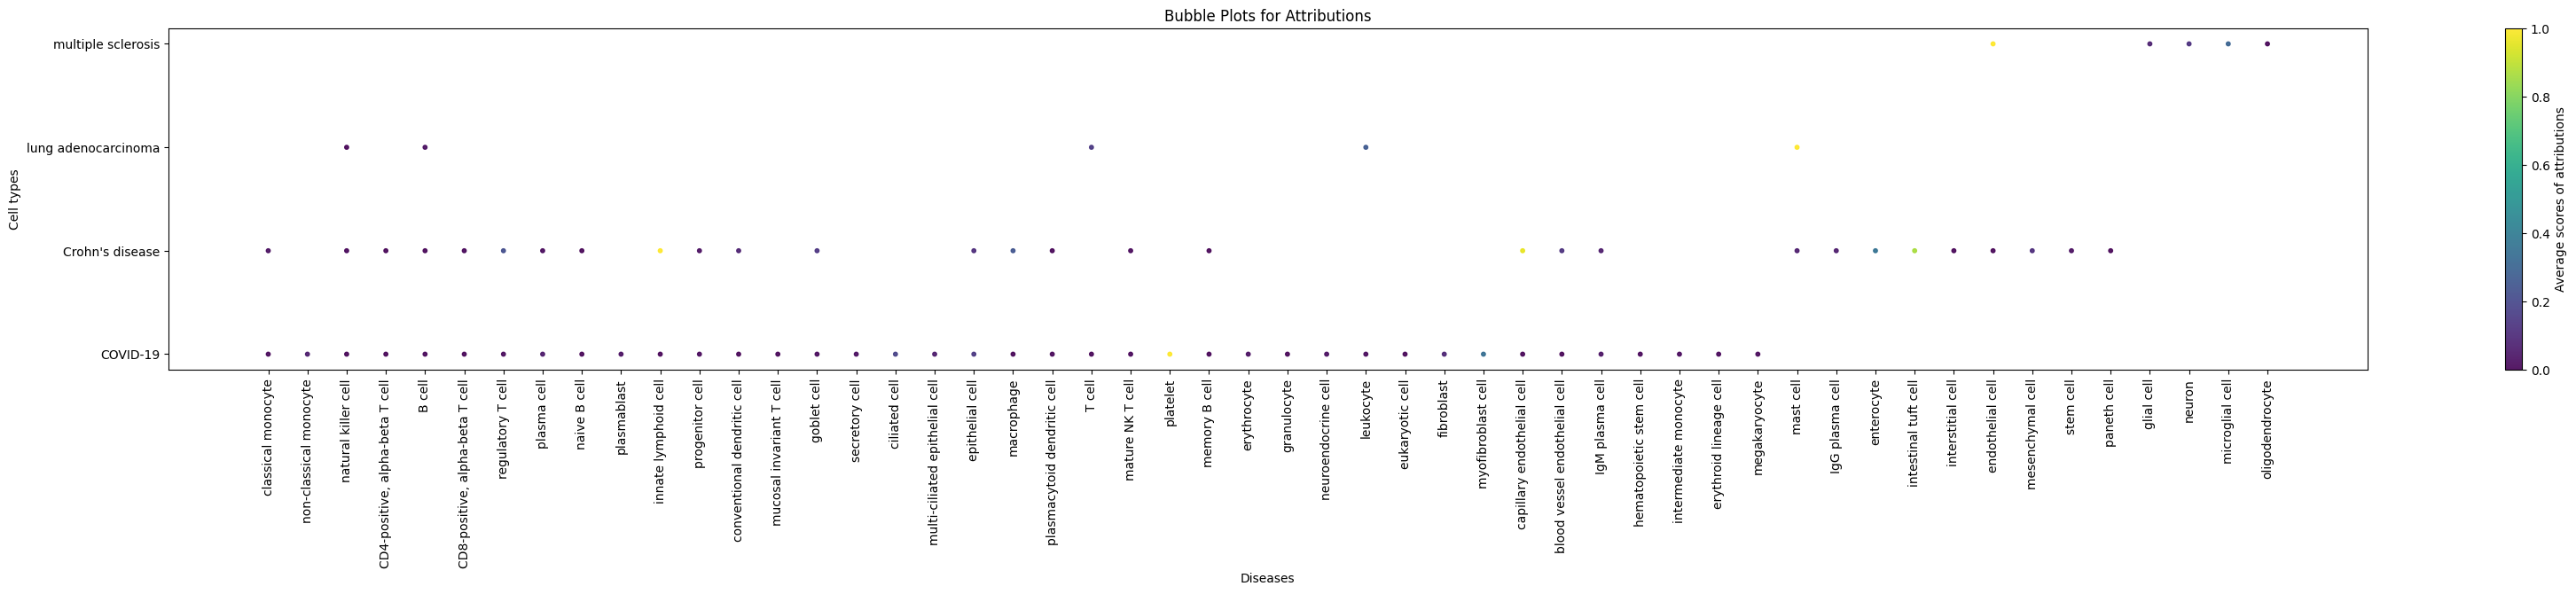

In [100]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'y': disease_list,
#     'x': celltype_list,
#     'color': MinMaxScaler().fit_transform(np.array(mean_list).reshape(-1,1)).T[0],
#     'size': MinMaxScaler().fit_transform(np.array(variance_list).reshape(-1,1)).T[0]*100  # Bubble sizes
# }
# df = pd.DataFrame(data)

# # Create the plot
# plt.figure(figsize=(14, 5))
# bubble = plt.scatter('x', 'y', s='size', c='color', alpha=0.9, data=df)

# # # Adding color bar
# # plt.colorbar(bubble, label='Color Scale')

# # # Create legends for sizes
# # for size in [100, 300, 500]:
# #     plt.scatter([], [], c='k', alpha=0.3, s=size,
# #                 label=str(size) + ' Size')
# # plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Bubble Sizes')

# # Labeling
# plt.ylabel('Diseases')
# plt.xlabel('Cell types')
# plt.title('Bubble Plots for Attributions')
# plt.xticks(rotation=90)
# # # Show plot
# # plt.show()
# plt.savefig('./bubbleplot_data_diseasetest.pdf',dpi=300)


import pandas as pd
import matplotlib.pyplot as plt

# Sample data
data = {
    'y': disease_list,
    'x': celltype_list,
    'color': mean_list_f,
    'size': 10  # Bubble sizes
}
df = pd.DataFrame(data)

# Create the plot
plt.figure(figsize=(40,5))
bubble = plt.scatter('x', 'y', s='size', c='color', alpha=0.9, data=df)

# Adding color bar
plt.colorbar(bubble, label='Average scores of attributions')

# # Create legends for sizes
# for size in [100, 300, 500]:
#     plt.scatter([], [], c='k', alpha=0.3, s=size,
#                 label=str(size) + ' Size')
# plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='Bubble Sizes')

# Labeling
plt.xlabel('Diseases')
plt.xticks(rotation=90)
plt.ylabel('Cell types')
plt.title('Bubble Plots for Attributions')
# plt.savefig('./bubbleplot_data_alldiseasetest.pdf')
# Show plot
plt.show()

                     y                                x     color
0             COVID-19               classical monocyte  0.011149
1             COVID-19           non-classical monocyte  0.061033
2             COVID-19              natural killer cell  0.002011
3             COVID-19  CD4-positive, alpha-beta T cell  0.002684
4             COVID-19                     mixed B cell  0.004034
..                 ...                              ...       ...
72  multiple sclerosis                 endothelial cell  1.000000
73  multiple sclerosis                       glial cell  0.071939
74  multiple sclerosis                           neuron  0.119930
75  multiple sclerosis                  microglial cell  0.298385
76  multiple sclerosis                  oligodendrocyte  0.000000

[77 rows x 3 columns]


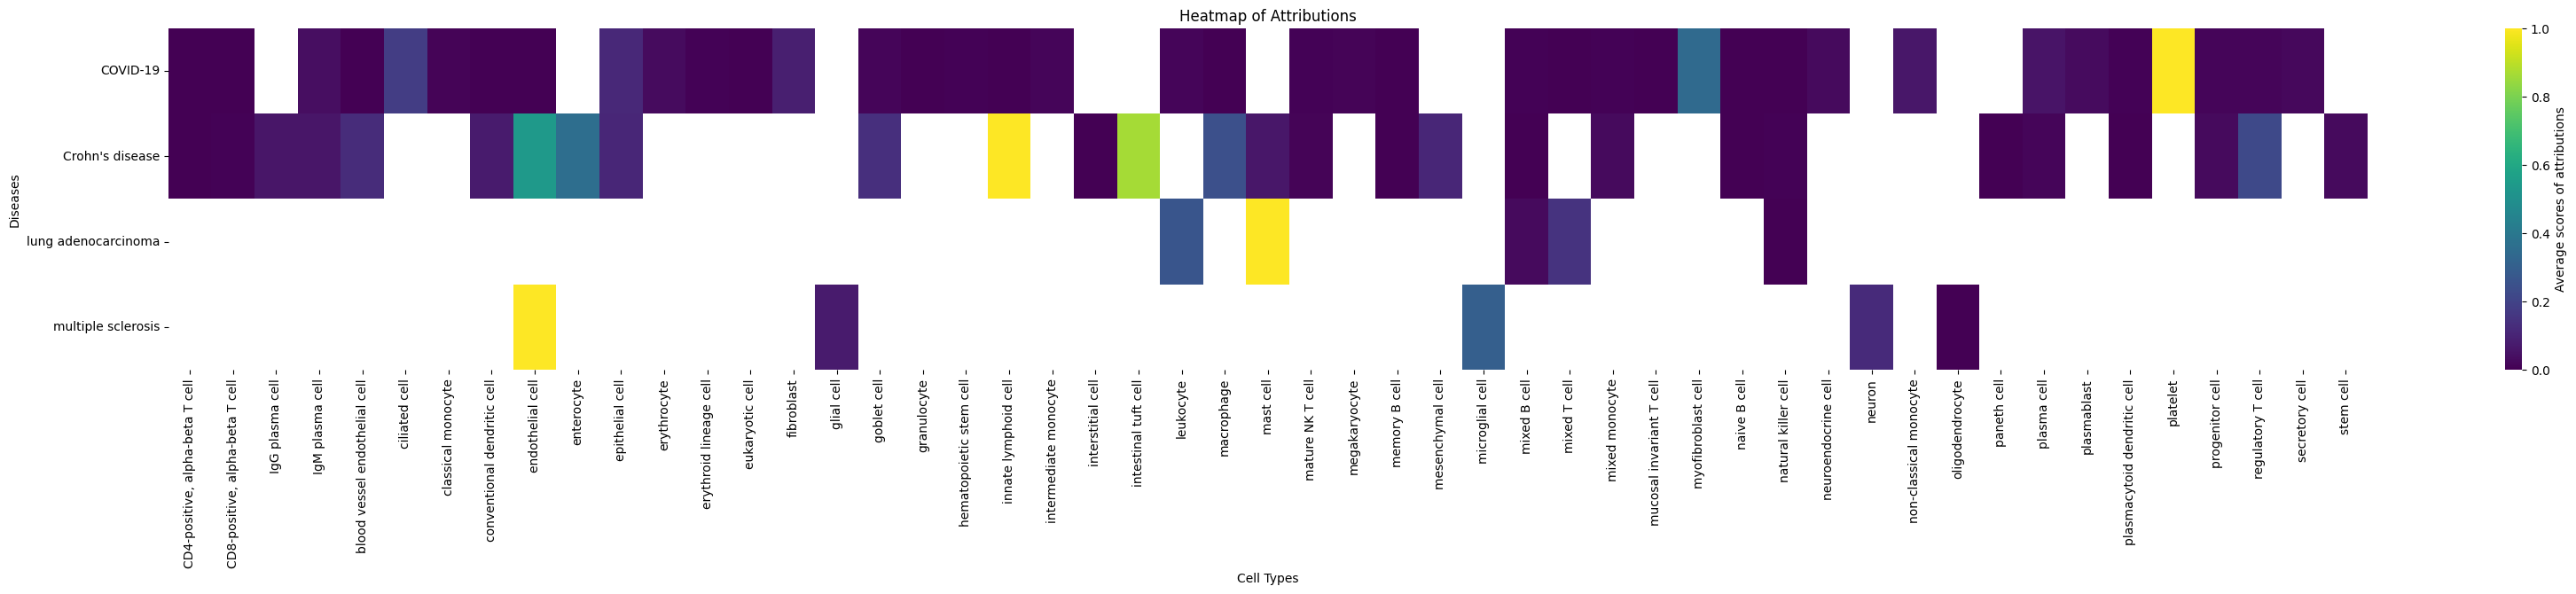

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data
data = {
    'y': disease_list,
    'x': celltype_list,
    'color': mean_list_f,  # Heatmap colors
}
df = pd.DataFrame(data)

# Pivot the data for heatmap

print(df)
heatmap_data = df.pivot(index='y', columns= 'x', values='color')

# Create the heatmap
plt.figure(figsize=(40, 5))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Average scores of attributions'})

# Labeling
plt.xlabel('Cell Types')
plt.xticks(rotation=90)
plt.ylabel('Diseases')
plt.title('Heatmap of Attributions')

# Show plot
plt.savefig('./bubbleplot_data_alldiseasetest_cleandata_update.pdf')
plt.show()

                     y                                x     color
0             COVID-19               classical monocyte  0.010555
1             COVID-19           non-classical monocyte  0.061033
2             COVID-19              natural killer cell  0.002011
3             COVID-19  CD4-positive, alpha-beta T cell  0.002684
4             COVID-19                           B cell  0.004034
..                 ...                              ...       ...
73  multiple sclerosis                       glial cell  0.071939
74  multiple sclerosis                 endothelial cell  1.000000
75  multiple sclerosis                           neuron  0.119930
76  multiple sclerosis                  microglial cell  0.298385
77  multiple sclerosis                  oligodendrocyte  0.000000

[78 rows x 3 columns]


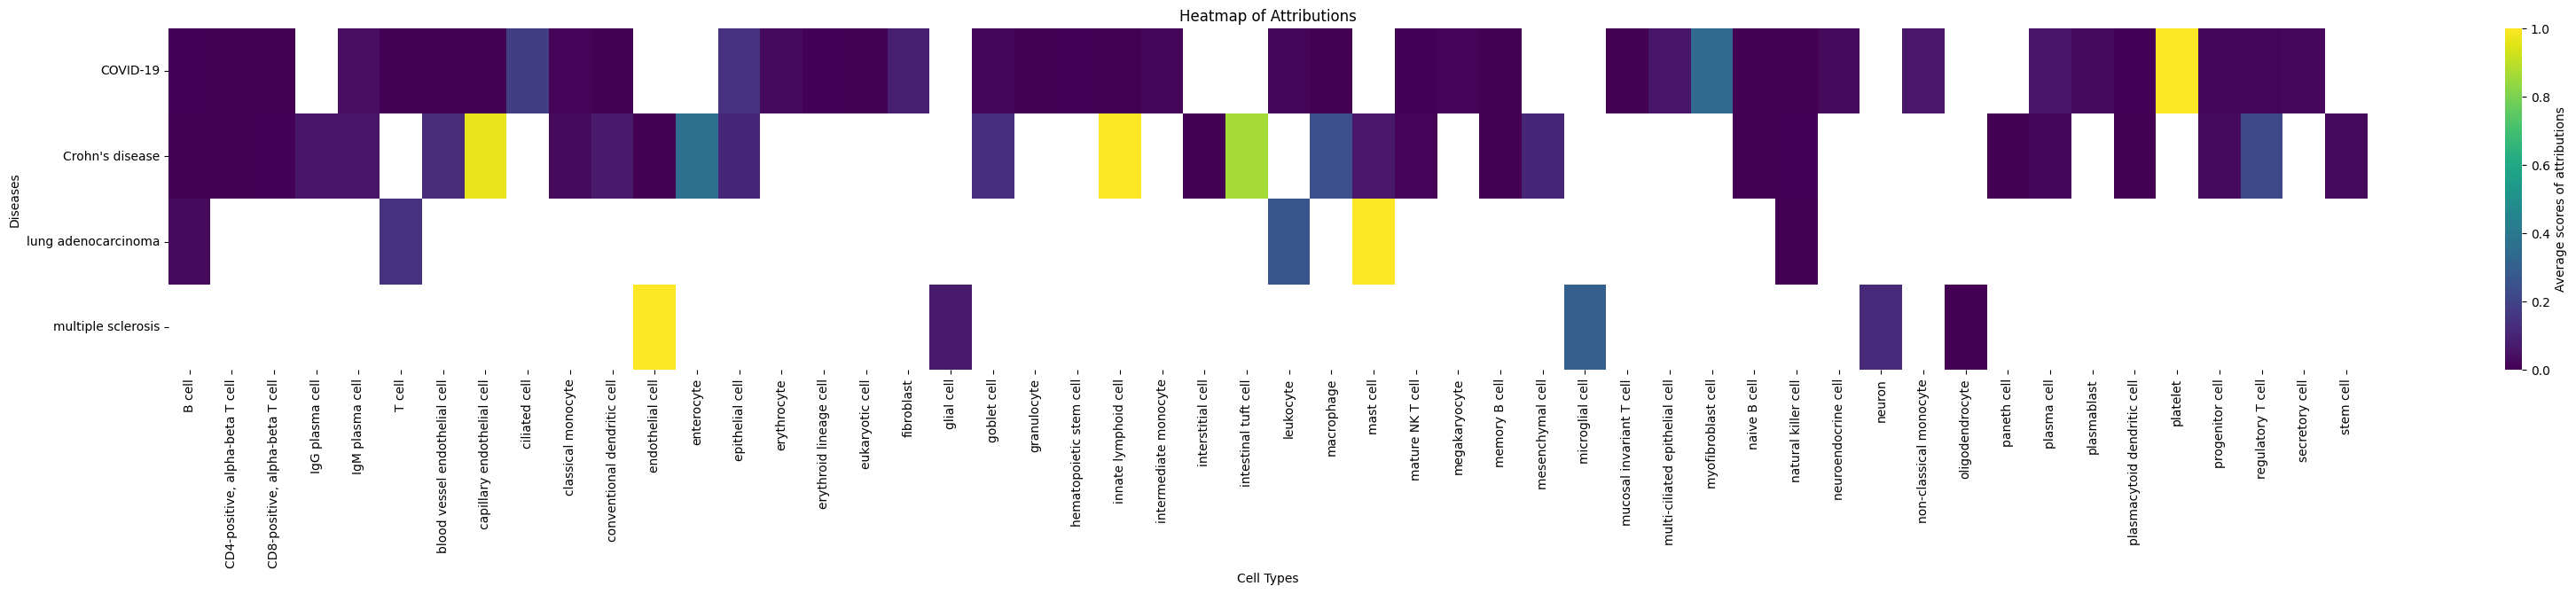

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Sample data
data = {
    'y': disease_list,
    'x': celltype_list,
    'color': mean_list_f,  # Heatmap colors
}
df = pd.DataFrame(data)

# Pivot the data for heatmap

print(df)
heatmap_data = df.pivot(index='y', columns= 'x', values='color')

# Create the heatmap
plt.figure(figsize=(40, 5))
sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Average scores of attributions'})

# Labeling
plt.xlabel('Cell Types')
plt.xticks(rotation=90)
plt.ylabel('Diseases')
plt.title('Heatmap of Attributions')

# Show plot
plt.savefig('./bubbleplot_data_alldiseasetest_cleandata.pdf')
plt.show()

In [102]:
a = 1